# CNN LSTM Model

50.039 Theory and Practice of Deep Learning Project

In [8]:
!pip install torchinfo

In [7]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from Preprocessor import *
from Constants import *

from tqdm import tqdm
from torchinfo import summary
from IPython.display import Audio
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'torchinfo'

In [5]:
#Convert Dataset into Pandas Dataframe
Tess = "./TESS"

tess_directory_list = os.listdir(Tess)
preprocessor = DataPreprocessor()   
file_paths, labels = preprocessor.get_file_paths_and_labels(Tess)

EMOTION_ENCODING = {'neutral':0,'happy':1, 'sad':2, 'angry':3, 'fear':4, 'disgust':5, 'ps':6}
encoded_labels = [EMOTION_ENCODING[label] for label in labels]
emotion_df = pd.DataFrame(labels, columns=['Emotions'])
print("ALL EMOTIONS:", set(labels))

path_df = pd.DataFrame(file_paths, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

ALL EMOTIONS: {'happy', 'fear', 'neutral', 'ps', 'disgust', 'sad', 'angry'}


,Emotions,Path
0,sad,./TESS/YAF_sad/YAF_wife_sad.wav
1,sad,./TESS/YAF_sad/YAF_hate_sad.wav
2,sad,./TESS/YAF_sad/YAF_phone_sad.wav
3,sad,./TESS/YAF_sad/YAF_week_sad.wav
4,sad,./TESS/YAF_sad/YAF_raid_sad.wav


# Data Preprocessing

In [8]:
#Extracting mel spectrograms from Dataset
signals = preprocessor.extract_audio_signals(Tess_df['Path'])
mel_spectograms = preprocessor.extract_mel_spectograms(signals)

 Processed 2799/2800 files

In [59]:
#Spliting extracted mel spectrogram data into training, testing and validation set
X_train, X_val, X_test, Y_train, Y_val, Y_test = preprocessor.train_val_test_split(mel_spectograms, encoded_labels)

In [ ]:
#Scaling and reshape Data for training
X_train = preprocessor.reshape_scale_data(X_train)
X_test = preprocessor.reshape_scale_data(X_test)
X_val = preprocessor.reshape_scale_data(X_val)

# Visualizing mel spectrograms

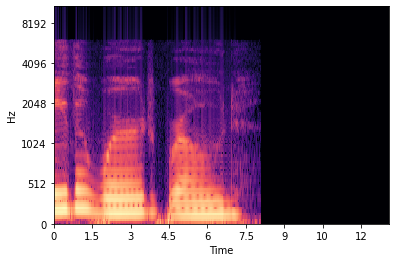

In [60]:
librosa.display.specshow(X_train[3].squeeze(), y_axis='mel', x_axis='time',cmap='magma')

# Create the model

In [13]:
class CNN_LSTM(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        conv2d_1 = nn.Conv2d(in_channels=1, out_channels=16, stride=1, padding=1, kernel_size=3)
        conv2d_2 = nn.Conv2d(in_channels=16, out_channels=32, stride=1, padding=1, kernel_size=3)
        conv2d_3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, padding=1, kernel_size=3)
        conv2d_4 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, padding=1, kernel_size=3)
        relu = nn.ReLU()
        maxPool2_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        maxPool4_4 = nn.MaxPool2d(kernel_size=4, stride=4)
        dropOut = nn.Dropout(p=0.3)
        batchNorm16 = nn.BatchNorm2d(16)
        batchNorm32 = nn.BatchNorm2d(32)
        batchNorm64 = nn.BatchNorm2d(64)
        
        #Convolution Block
        self.conv2Dblock = nn.Sequential(conv2d_1, batchNorm16, relu, maxPool2_2, dropOut,
                                         conv2d_2, batchNorm32, relu, maxPool4_4, dropOut,
                                         conv2d_3, batchNorm64, relu, maxPool4_4, dropOut,
                                         conv2d_4, batchNorm64, relu, maxPool4_4, dropOut)
        
        #LSTM Block (NEEED WORKKKKKKKKKKKKKKKKKK)
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        #Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        #Convolutional Embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        #LSTM Embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b,time,hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm

In [14]:
def loss_func(predictions, targets):
    loss = nn.CrossEntropyLoss()
    return loss(input=predictions,target=targets)

# TRAINING

In [15]:
def make_train_step(model, loss_func, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_func(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [16]:
def make_validate_func(model,loss_func):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_func(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

# Train the model

In [19]:
EPOCHS=150
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = CNN_LSTM(num_emotions=7).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.001, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_func, optimizer=OPTIMIZER)
validate = make_validate_func(model,loss_func)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = [Y_train[i] for i in ind] 
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")

Selected device is cuda
Number of trainable params:  262952
 Epoch 0: iteration 69/70
Epoch 0 --> loss:1.6325, acc:37.77%, val_loss:1.6460, val_acc:27.50%
 Epoch 1: iteration 69/70
Epoch 1 --> loss:1.2310, acc:53.57%, val_loss:1.4244, val_acc:50.71%
 Epoch 2: iteration 69/70
Epoch 2 --> loss:0.9423, acc:63.62%, val_loss:1.1860, val_acc:65.00%
 Epoch 3: iteration 69/70
Epoch 3 --> loss:0.8452, acc:68.21%, val_loss:0.9823, val_acc:75.00%
 Epoch 4: iteration 69/70
Epoch 4 --> loss:0.7394, acc:70.89%, val_loss:0.9577, val_acc:75.71%
 Epoch 5: iteration 69/70
Epoch 5 --> loss:0.6502, acc:75.13%, val_loss:0.8733, val_acc:83.57%
 Epoch 6: iteration 69/70
Epoch 6 --> loss:0.6110, acc:77.10%, val_loss:0.7373, val_acc:82.50%
 Epoch 7: iteration 69/70
Epoch 7 --> loss:0.5424, acc:81.16%, val_loss:0.7297, val_acc:82.86%
 Epoch 8: iteration 69/70
Epoch 8 --> loss:0.4877, acc:81.52%, val_loss:0.6989, val_acc:81.43%
 Epoch 9: iteration 69/70
Epoch 9 --> loss:0.4332, acc:84.15%, val_loss:0.8767, val_a

 Epoch 84: iteration 69/70
Epoch 84 --> loss:0.0133, acc:99.60%, val_loss:0.0933, val_acc:96.79%
 Epoch 85: iteration 69/70
Epoch 85 --> loss:0.0145, acc:99.73%, val_loss:0.0602, val_acc:97.86%
 Epoch 86: iteration 69/70
Epoch 86 --> loss:0.0126, acc:99.73%, val_loss:0.0536, val_acc:99.29%
 Epoch 87: iteration 69/70
Epoch 87 --> loss:0.0070, acc:100.00%, val_loss:0.0510, val_acc:98.93%
 Epoch 88: iteration 69/70
Epoch 88 --> loss:0.0081, acc:99.82%, val_loss:0.0584, val_acc:98.21%
 Epoch 89: iteration 69/70
Epoch 89 --> loss:0.0075, acc:99.91%, val_loss:0.0628, val_acc:97.50%
 Epoch 90: iteration 69/70
Epoch 90 --> loss:0.0085, acc:99.96%, val_loss:0.0625, val_acc:97.86%
 Epoch 91: iteration 69/70
Epoch 91 --> loss:0.0078, acc:99.91%, val_loss:0.0722, val_acc:97.86%
 Epoch 92: iteration 69/70
Epoch 92 --> loss:0.0078, acc:99.91%, val_loss:0.0437, val_acc:99.29%
 Epoch 93: iteration 69/70
Epoch 93 --> loss:0.0077, acc:99.91%, val_loss:0.0594, val_acc:98.57%
 Epoch 94: iteration 69/70
Ep

# Save model

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm.pt')))

# Load model

In [ ]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = ParallelModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm.pt2')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm.pt')))

# Test

In [21]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.104
Test accuracy is 95.36%


# Confusion Matrix

In [ ]:
predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

In [ ]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])